In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [6]:
F24_post = pd.read_csv('F24_pre_post_cleaned/F24_post_survey_data.csv')
F24_glossary = pd.read_csv('F24_pre_post_cleaned/F24_post_survey_dataset_glossary.csv')

In [25]:
def map_scale(column_data):
    """
    Determines the appropriate scale for the given column based on its unique values.

    Parameters:
    - column_data: Pandas Series containing the data for a column.

    Returns:
    - List of ordered categories if a matching scale is found, otherwise None.
    """
    # Define the scales
    scales = {
        "Time Spent Scale": ["6 or fewer hours", "6 to 9 hours", "9 to 12 hours", "12 or more hours"],
        "5-Star Rating Scale": ["1 (worst)", "2 stars", "3 stars", "3.5 stars", "4 stars", "4.5 stars", "5 (best)"],
        "Agreement Scale": ["Strongly disagree", "Disagree", "Neither Agree nor Disagree", "Agree", "Strongly agree"],
        "Quality Scale": ["Excellent", "Very Good", "Good", "Adequate", "Poor"],
        "Helpfulness Scale": ["Not Helpful", "Slightly Helpful", "Moderately Helpful", "Very Helpful", "Extremely Helpful", "Not Applicable"],
        "Competency Scale": ["Not at all", "Not very well", "Neutral", "Reasonably Well", "Extremely Well", "I don't know"],
    }

    # Compare unique values with each scale to find a match
    unique_values = sorted(column_data.dropna().unique(), key=str)
    for scale_name, scale in scales.items():
        if set(unique_values) <= set(scale):
            return scale
    return None

def generate_barplots(data, glossary, grouping_column, variable_column):
    """
    Generate grouped barplots with 3 columns per row for each group,
    including a small box in the top-left corner showing the average rating for Group 4.

    Parameters:
    - data: DataFrame containing the survey responses.
    - glossary: DataFrame containing the mapping of variables to groups.
    - grouping_column: Column in the glossary for grouping variables.
    - variable_column: Column in the glossary with variable names.
    """
    # Group the glossary by the grouping column
    grouped_glossary = glossary.groupby(grouping_column)

    for group_name, group_data in grouped_glossary:
        variables = group_data[variable_column].tolist()

        # Filter the columns in the data corresponding to the variables
        valid_columns = [col for col in variables if col in data.columns]
        if not valid_columns:
            continue

        # Create a single figure for the group with 3 columns per row
        num_vars = len(valid_columns)
        num_rows = (num_vars + 2) // 3  # Calculate the number of rows needed
        fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows), sharey=True)
        axes = axes.flatten()  # Flatten in case of multiple rows

        for i, (ax, col) in enumerate(zip(axes, valid_columns)):
            # Detect scale
            scale = map_scale(data[col])
            if scale:
                # Extract numerical values for averaging
                numerical_scale = [float(x.split()[0]) for x in scale if x.split()[0].replace(".", "").isdigit()]
                if numerical_scale:
                    avg_rating = data[col].apply(
                        lambda x: float(x.split()[0]) if isinstance(x, str) and x.split()[0].replace(".", "").isdigit() else None
                    ).mean()

                data[col].value_counts(normalize=True).reindex(scale).plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
                ax.set_title(col, fontsize=10)
                ax.set_xlabel('Responses', fontsize=8)
                ax.set_ylabel('Density', fontsize=8)
                ax.tick_params(axis='x', rotation=45, labelsize=8)
                
                # Add average rating box for Group 4
                if group_name == 4 and numerical_scale:
                    ax.text(
                        0.02, 0.95, f"Avg Rating: {avg_rating:.2f}",
                        transform=ax.transAxes, fontsize=10,
                        verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
                    )
            else:
                ax.text(0.5, 0.5, f"No scale detected for {col}", ha='center', va='center', fontsize=10)
                ax.axis('off')

        # Hide any unused subplots
        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.suptitle(f"Question: {group_name}", fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()


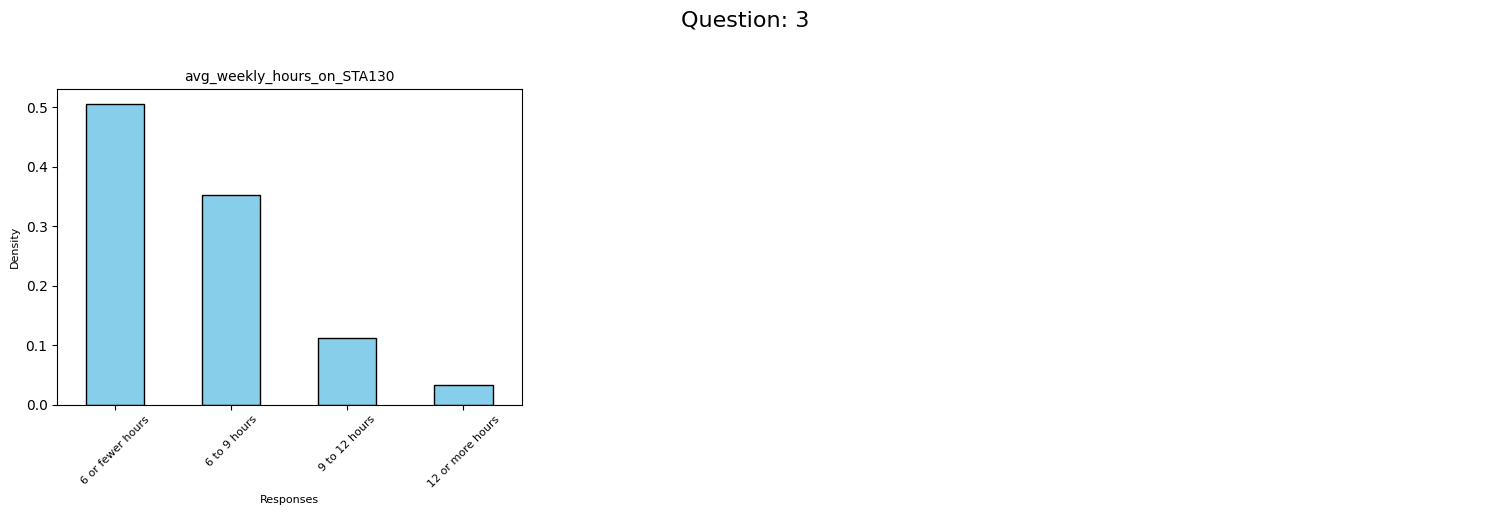

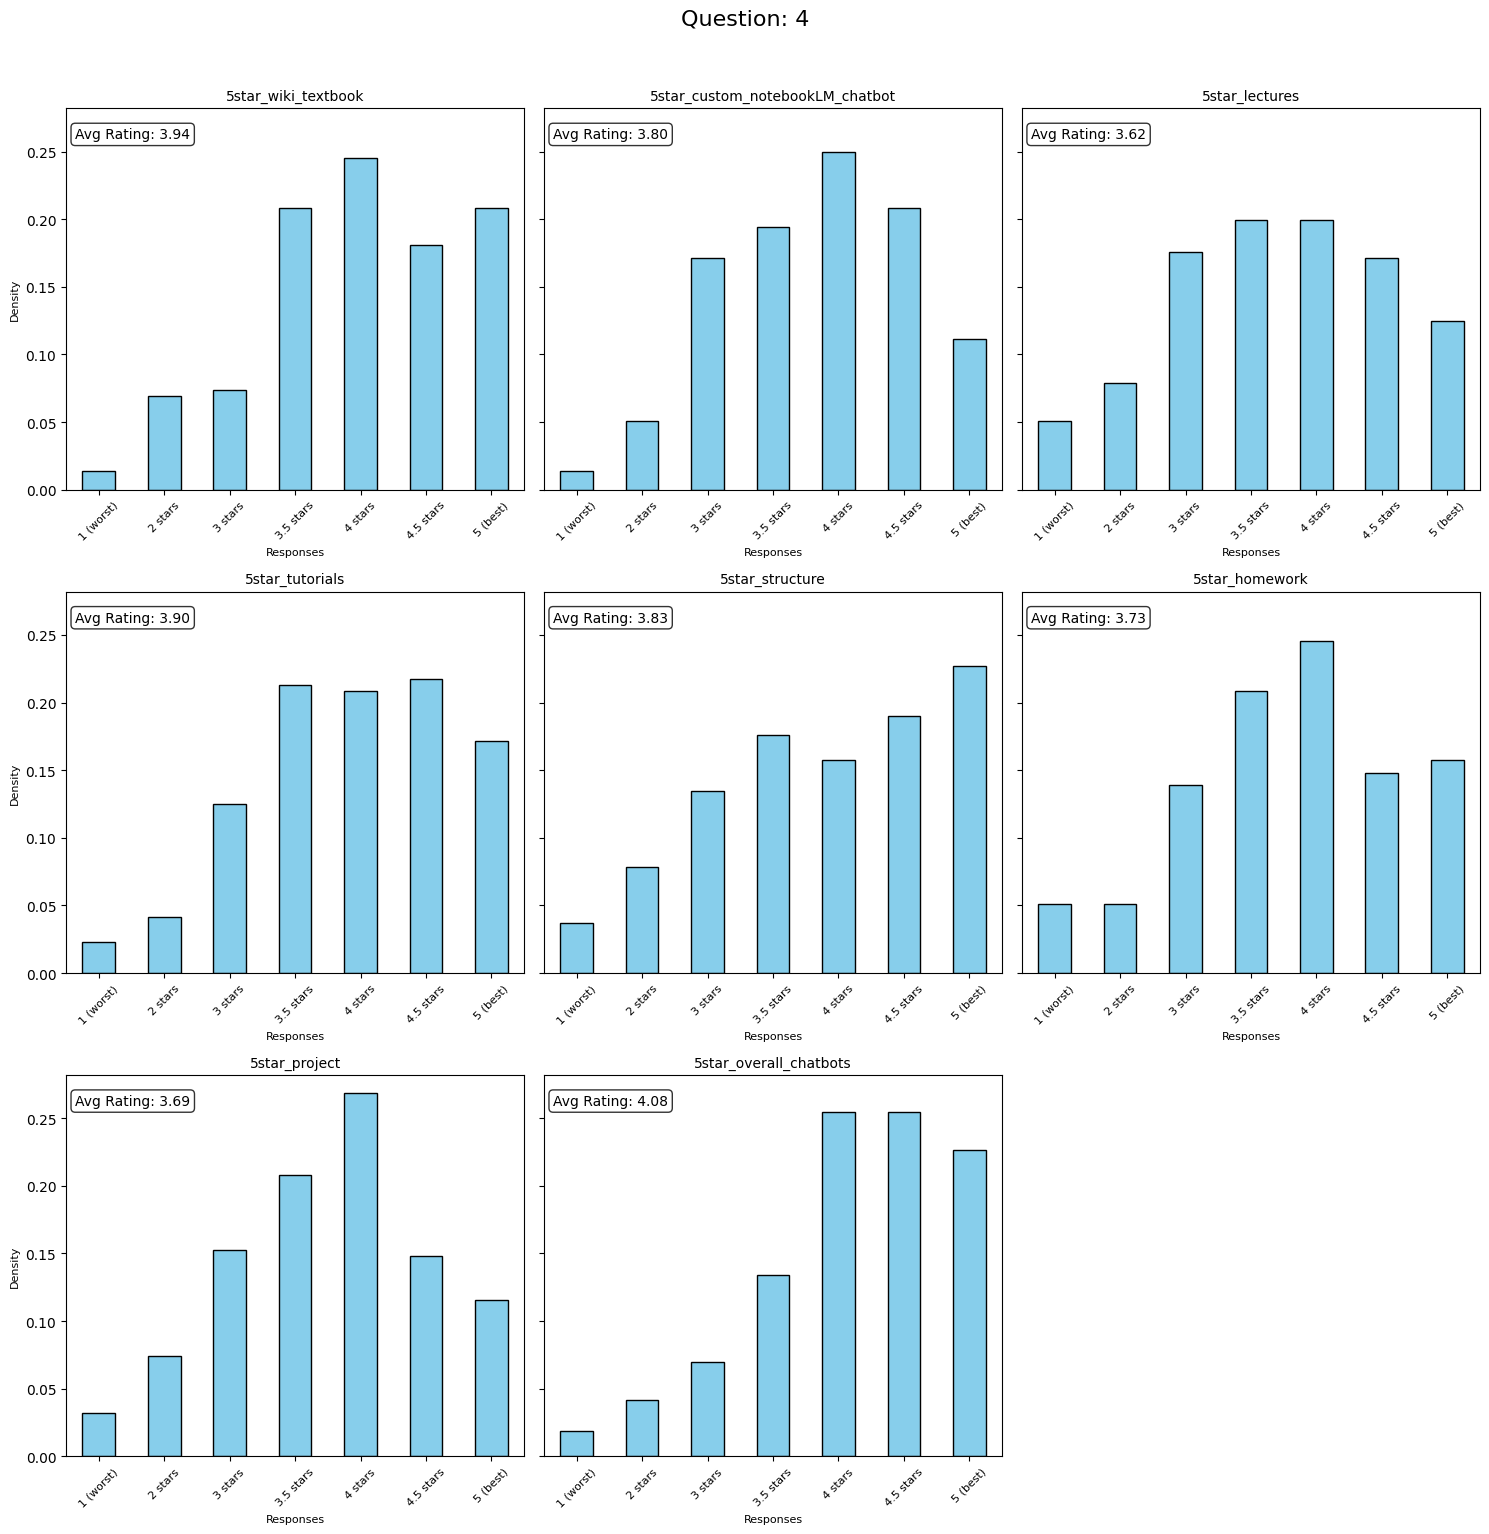

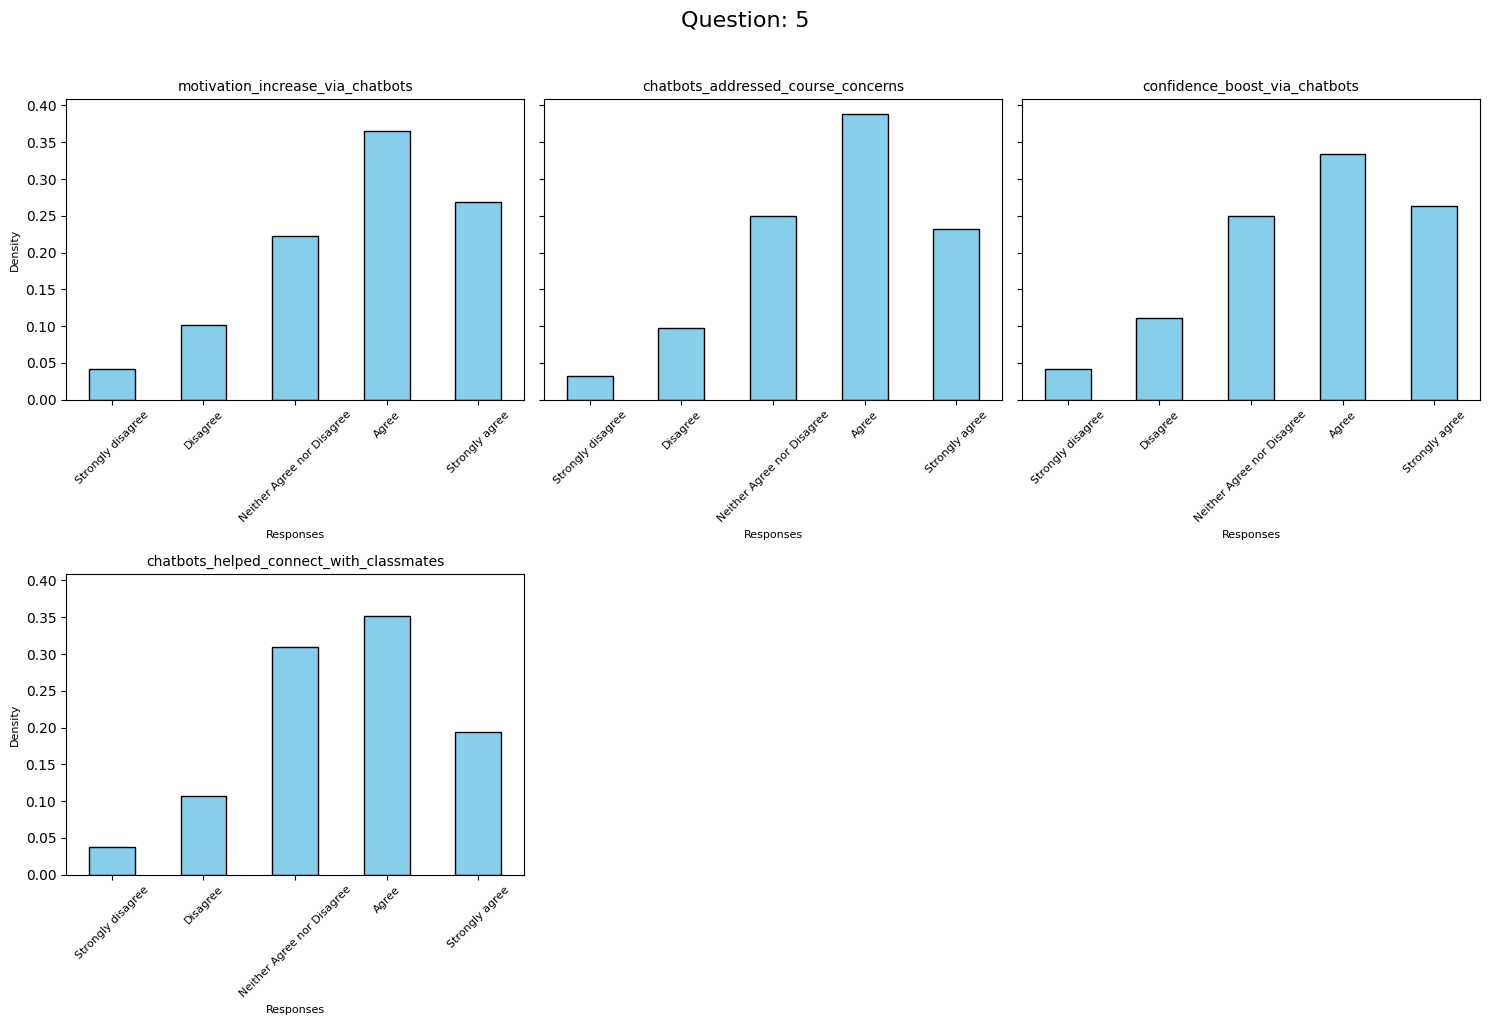

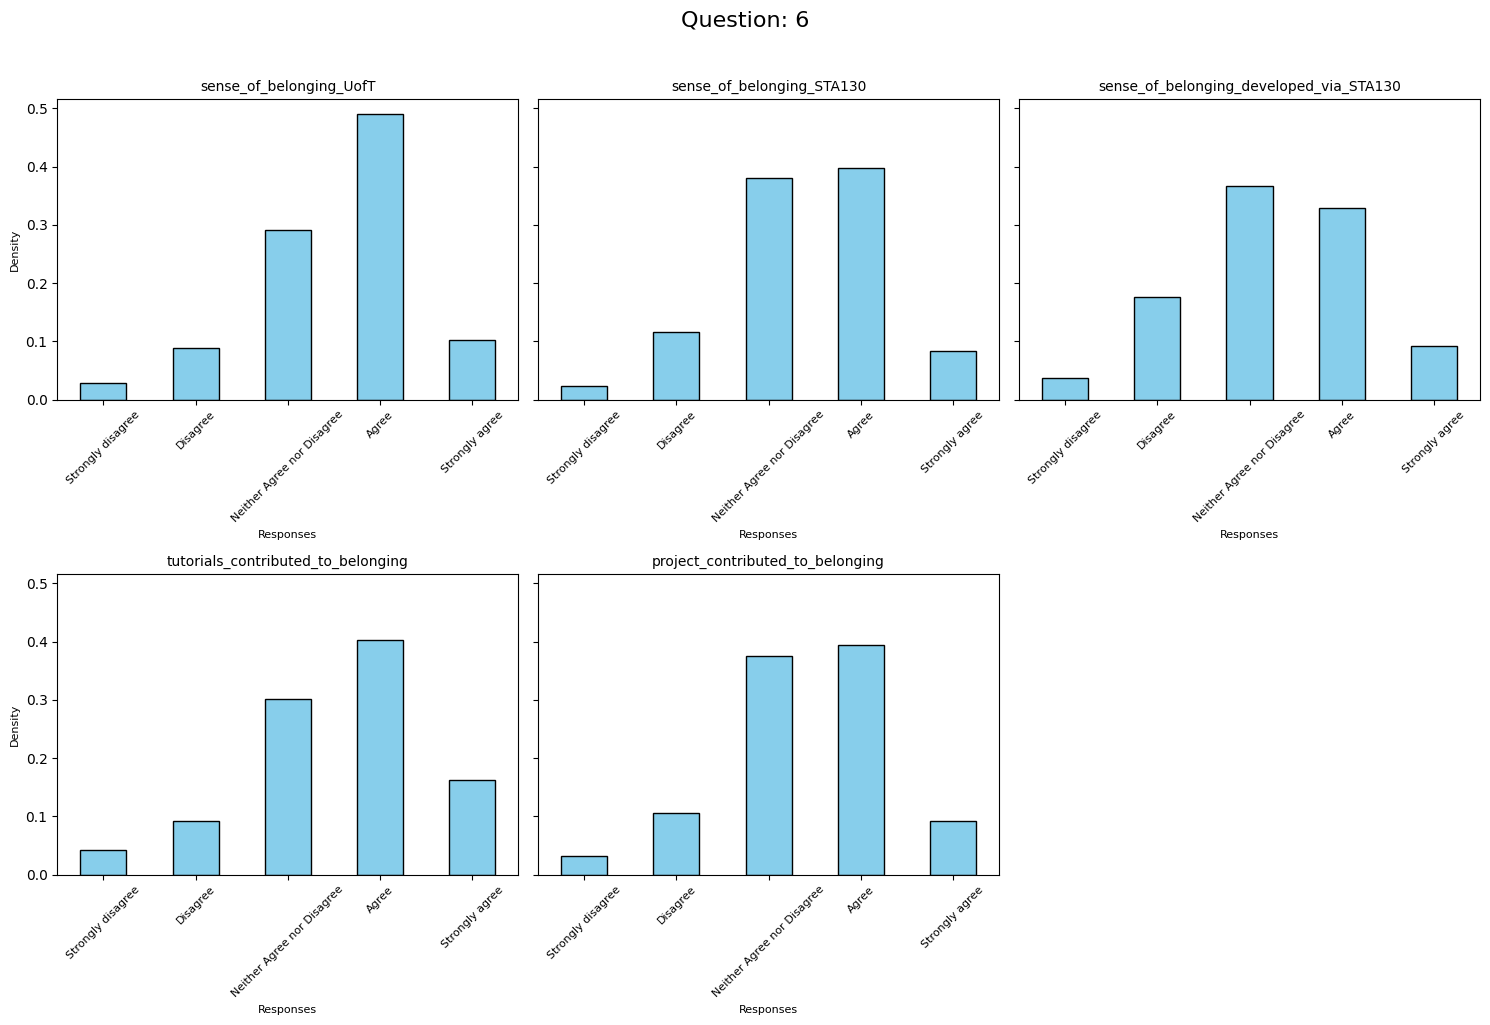

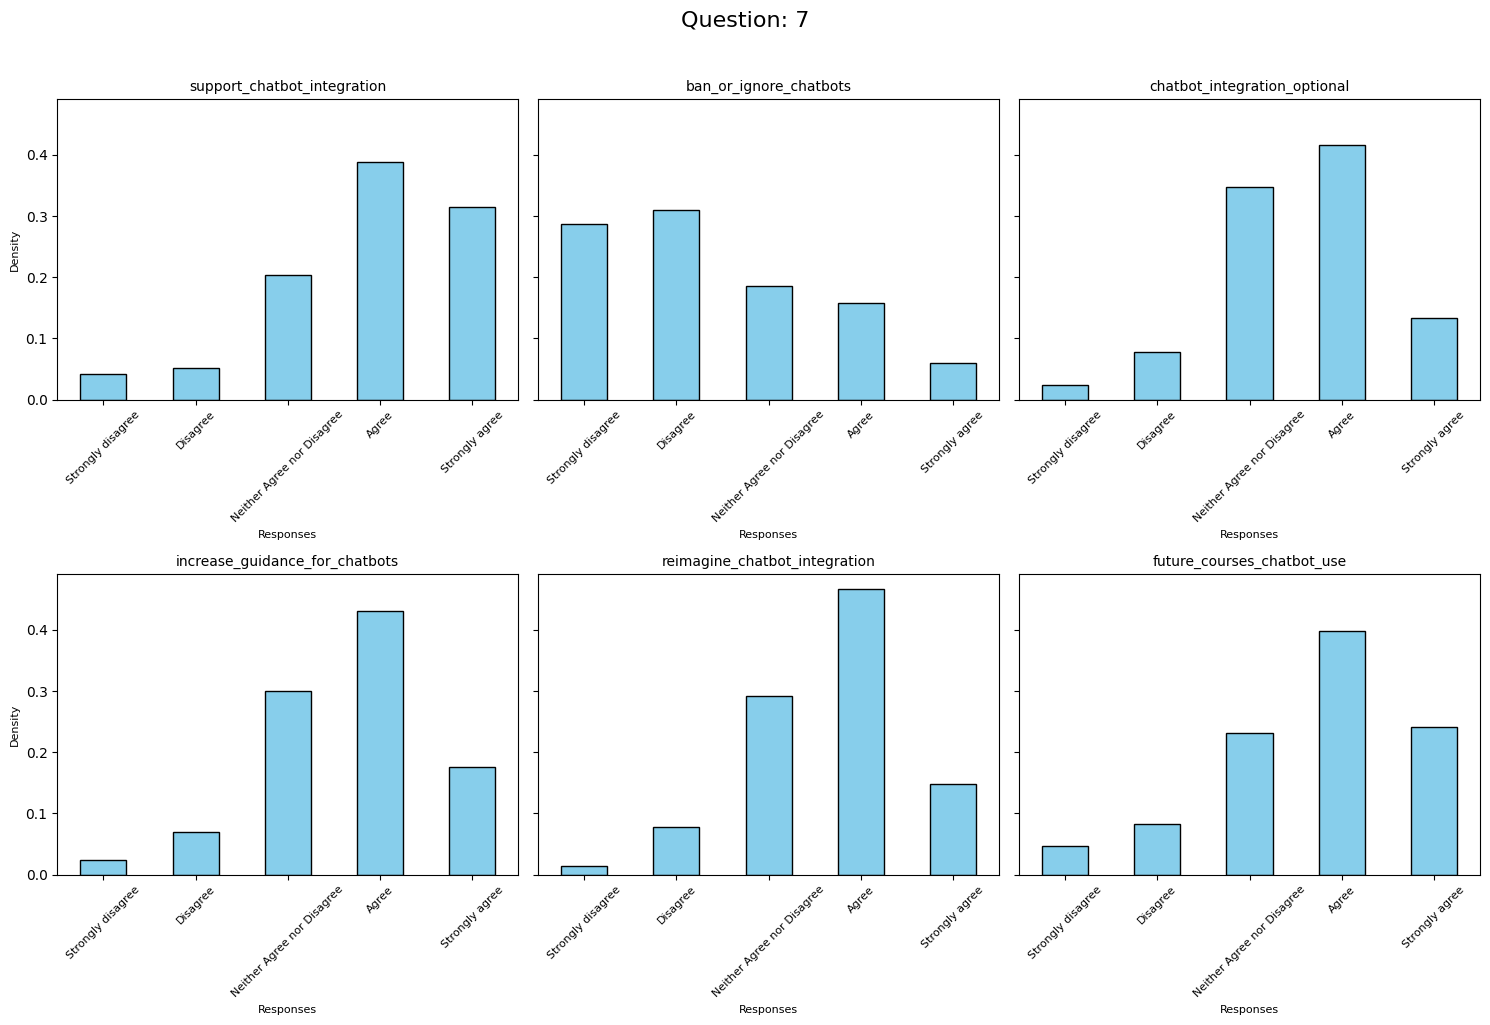

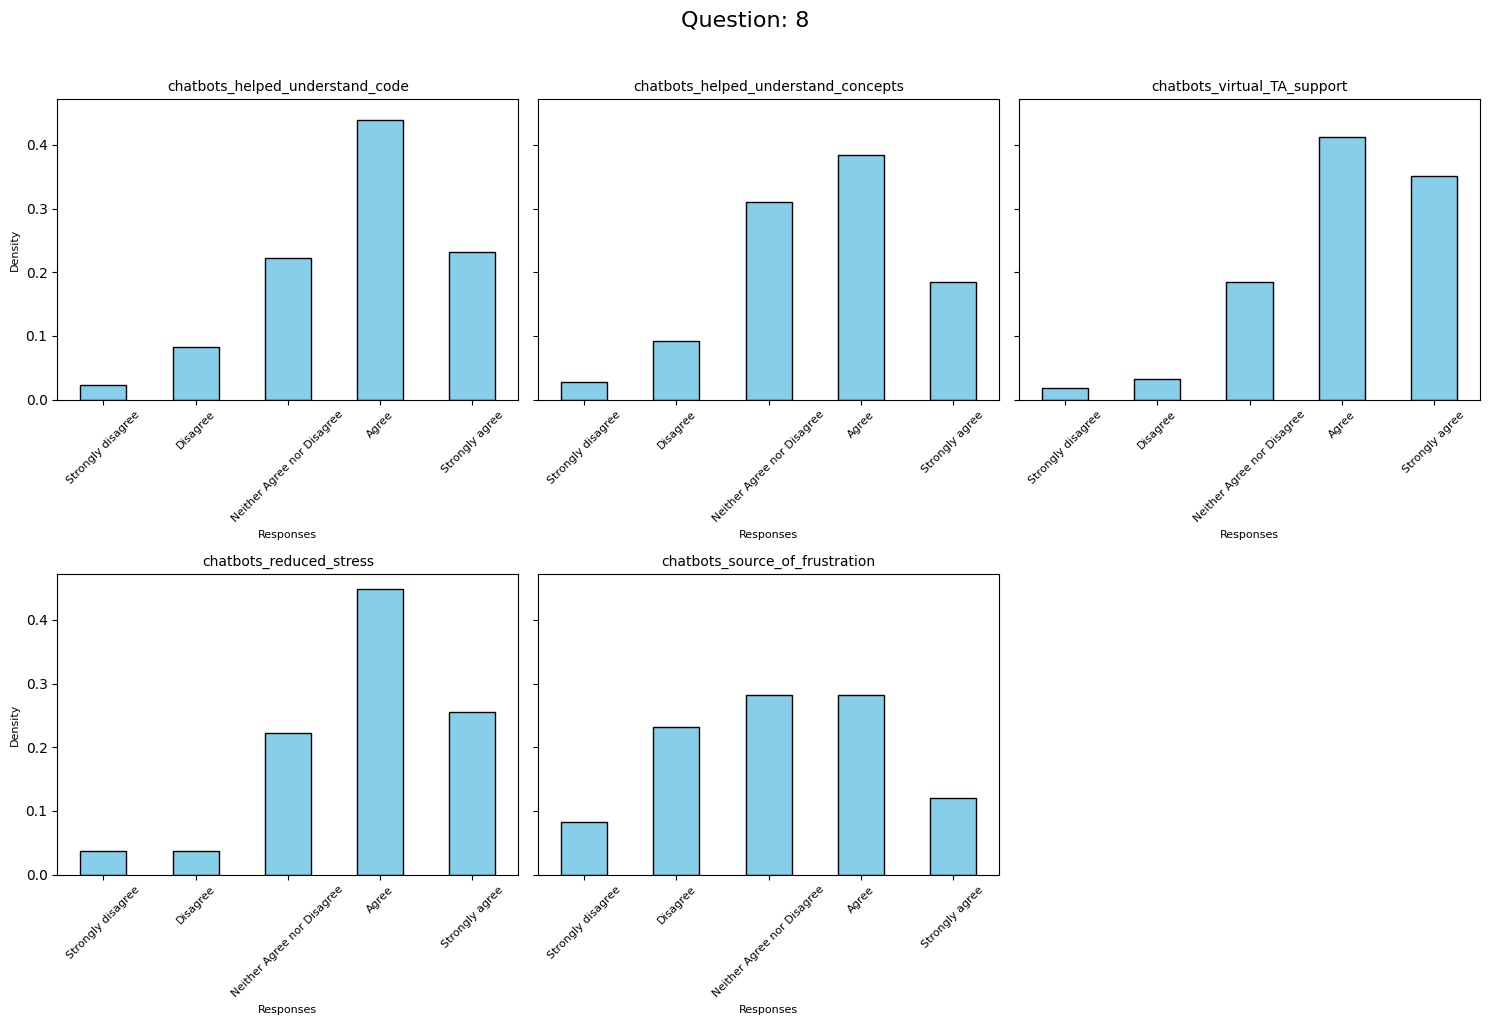

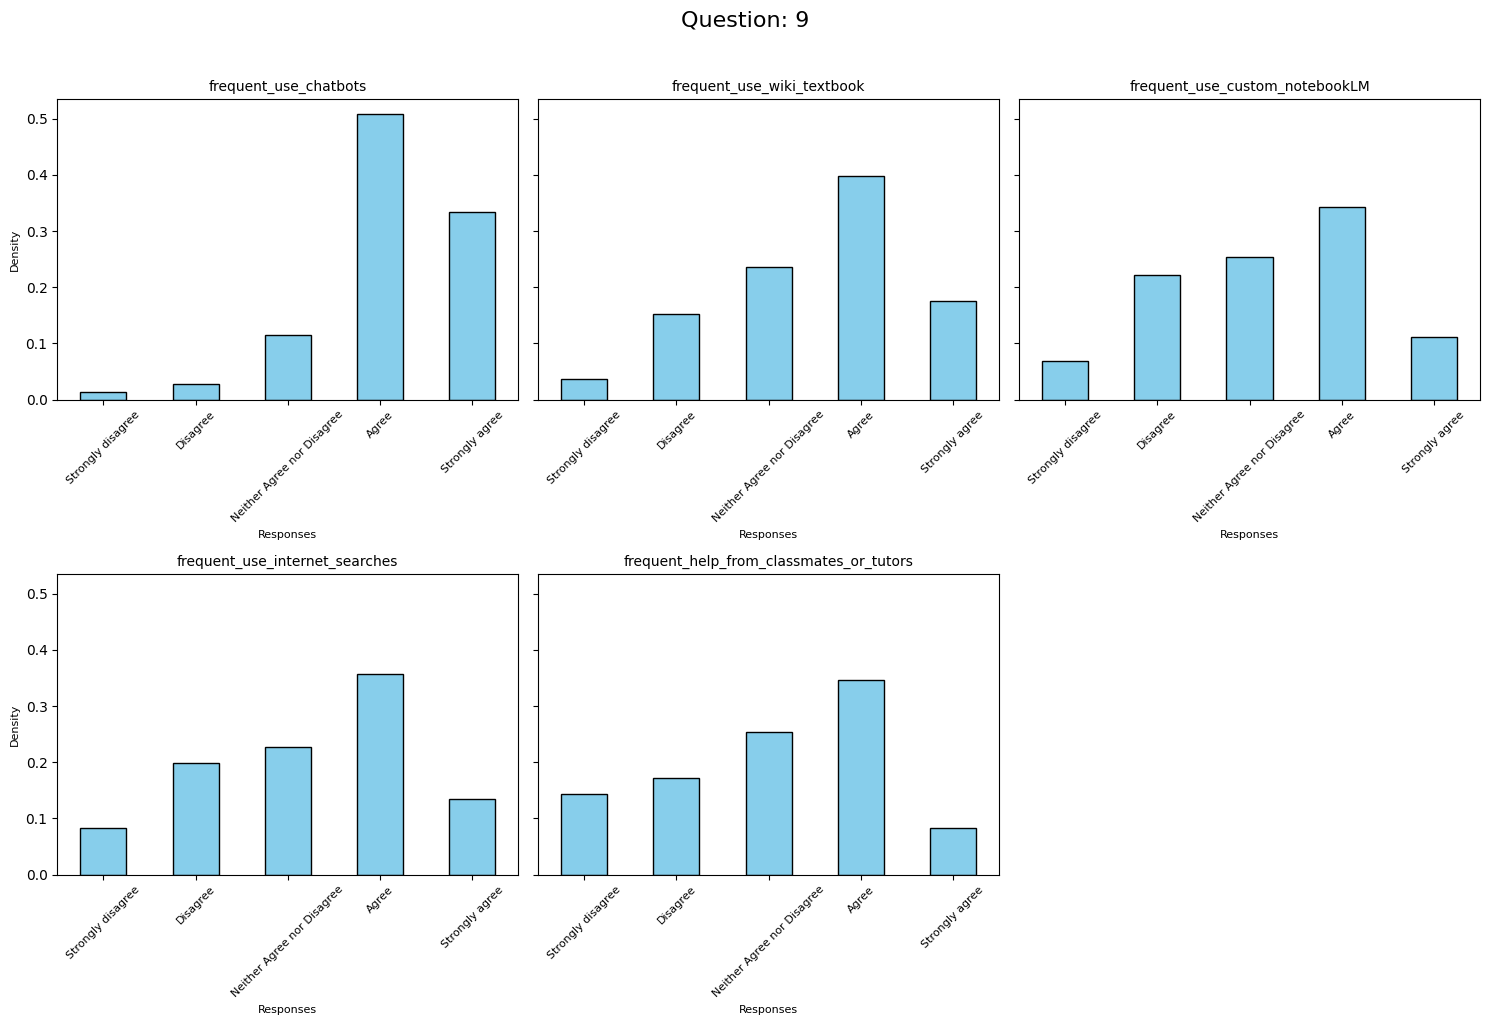

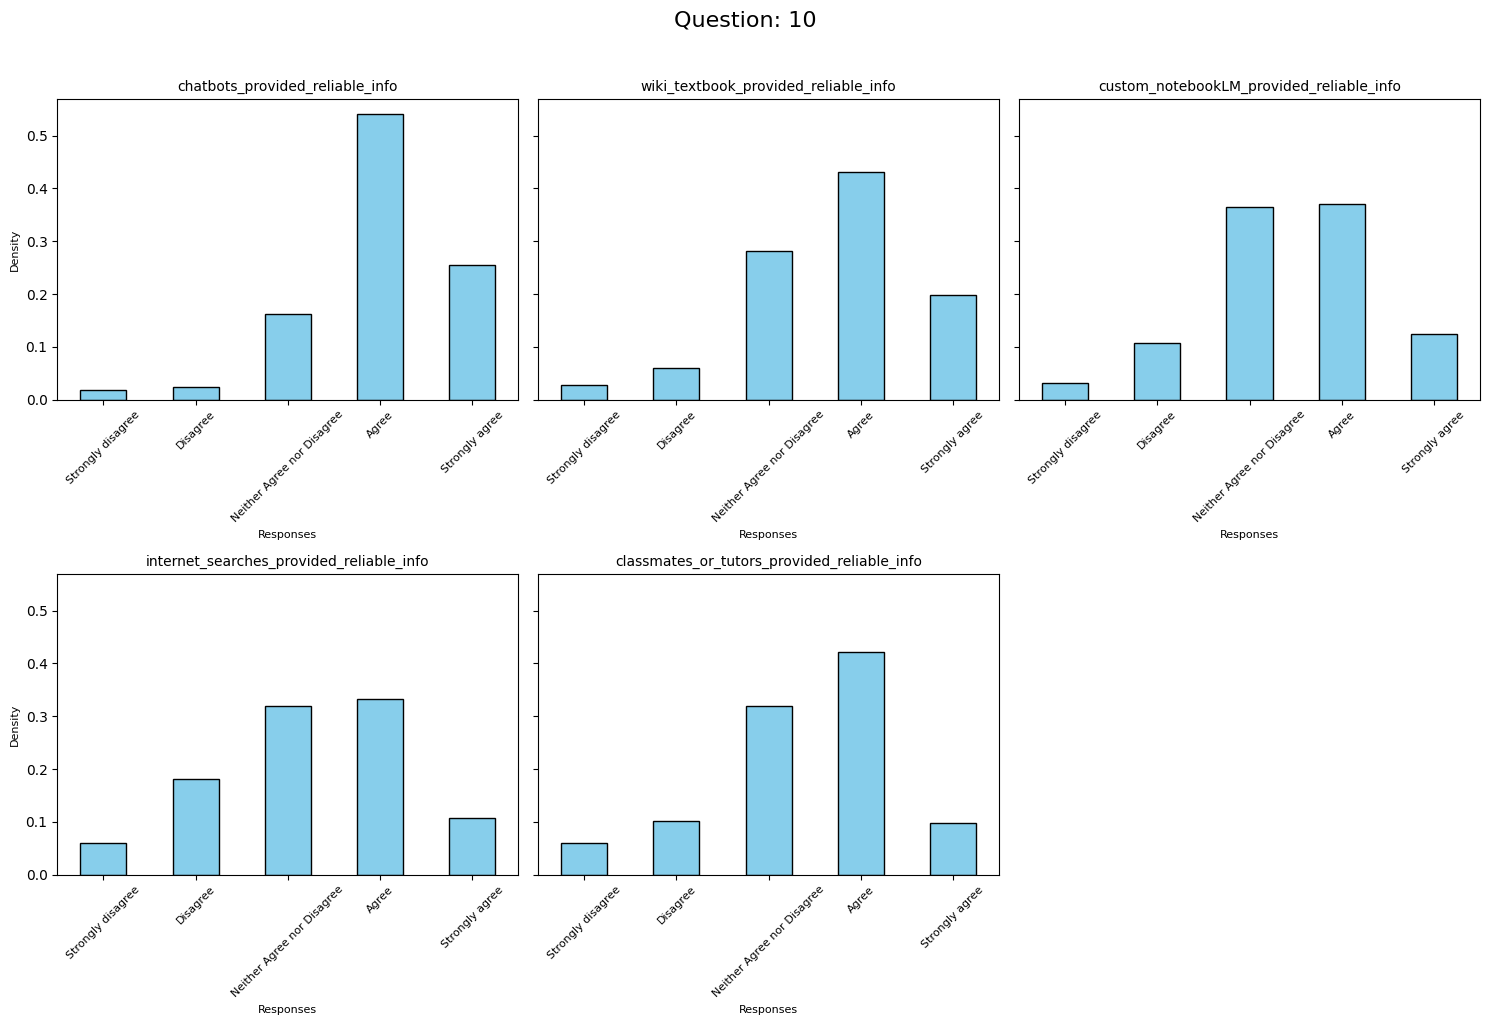

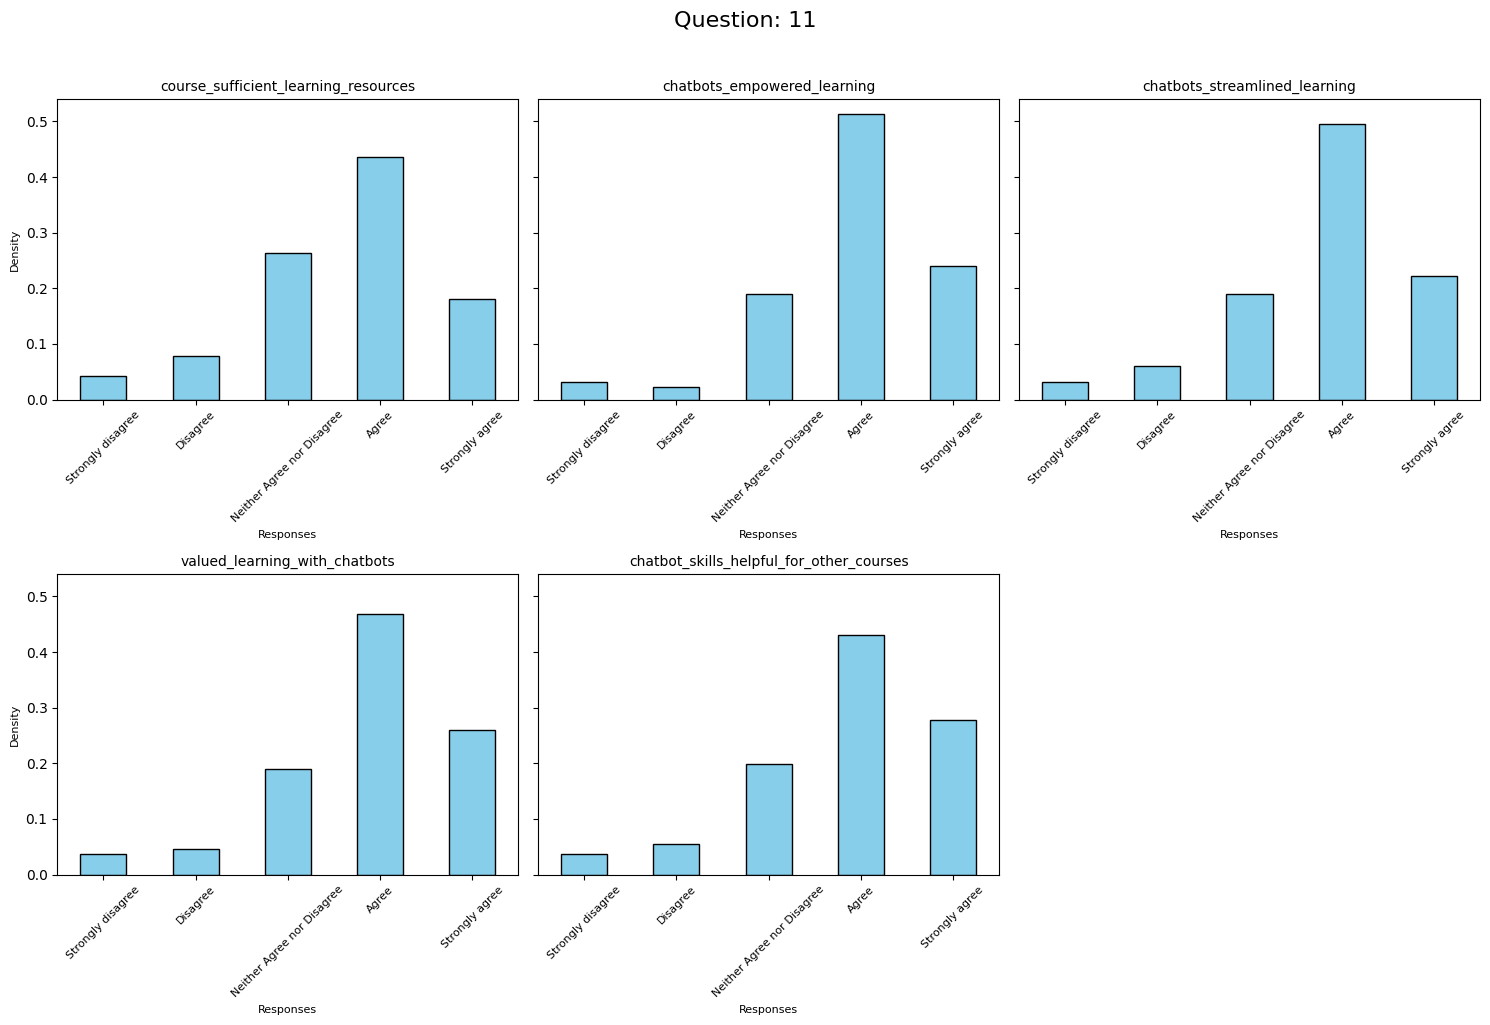

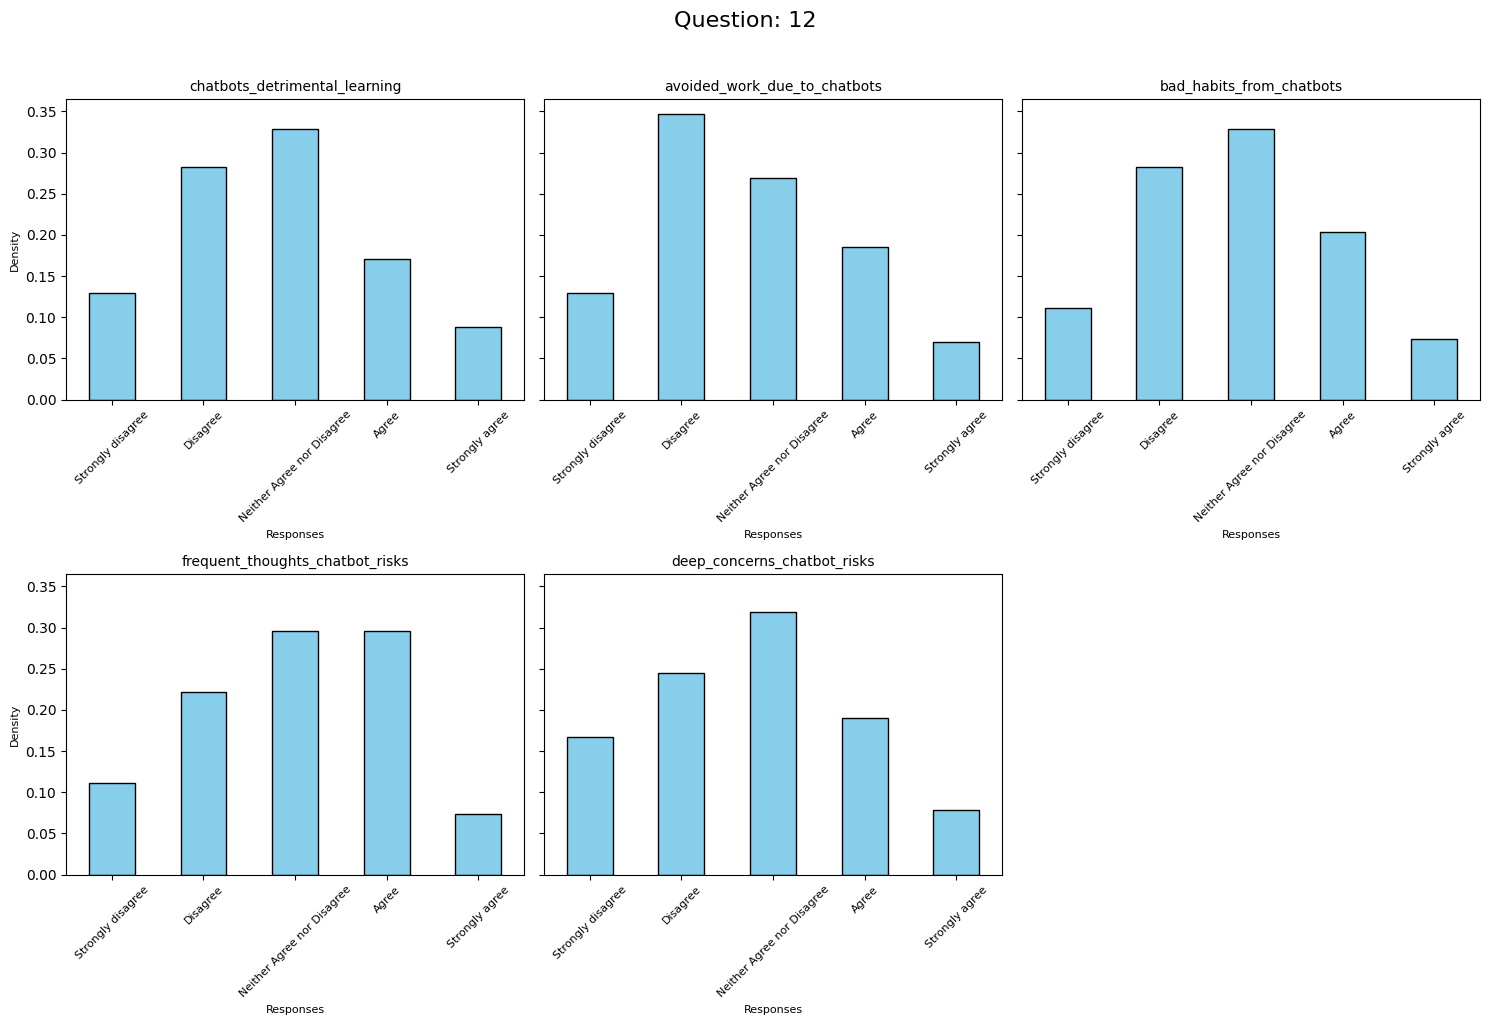

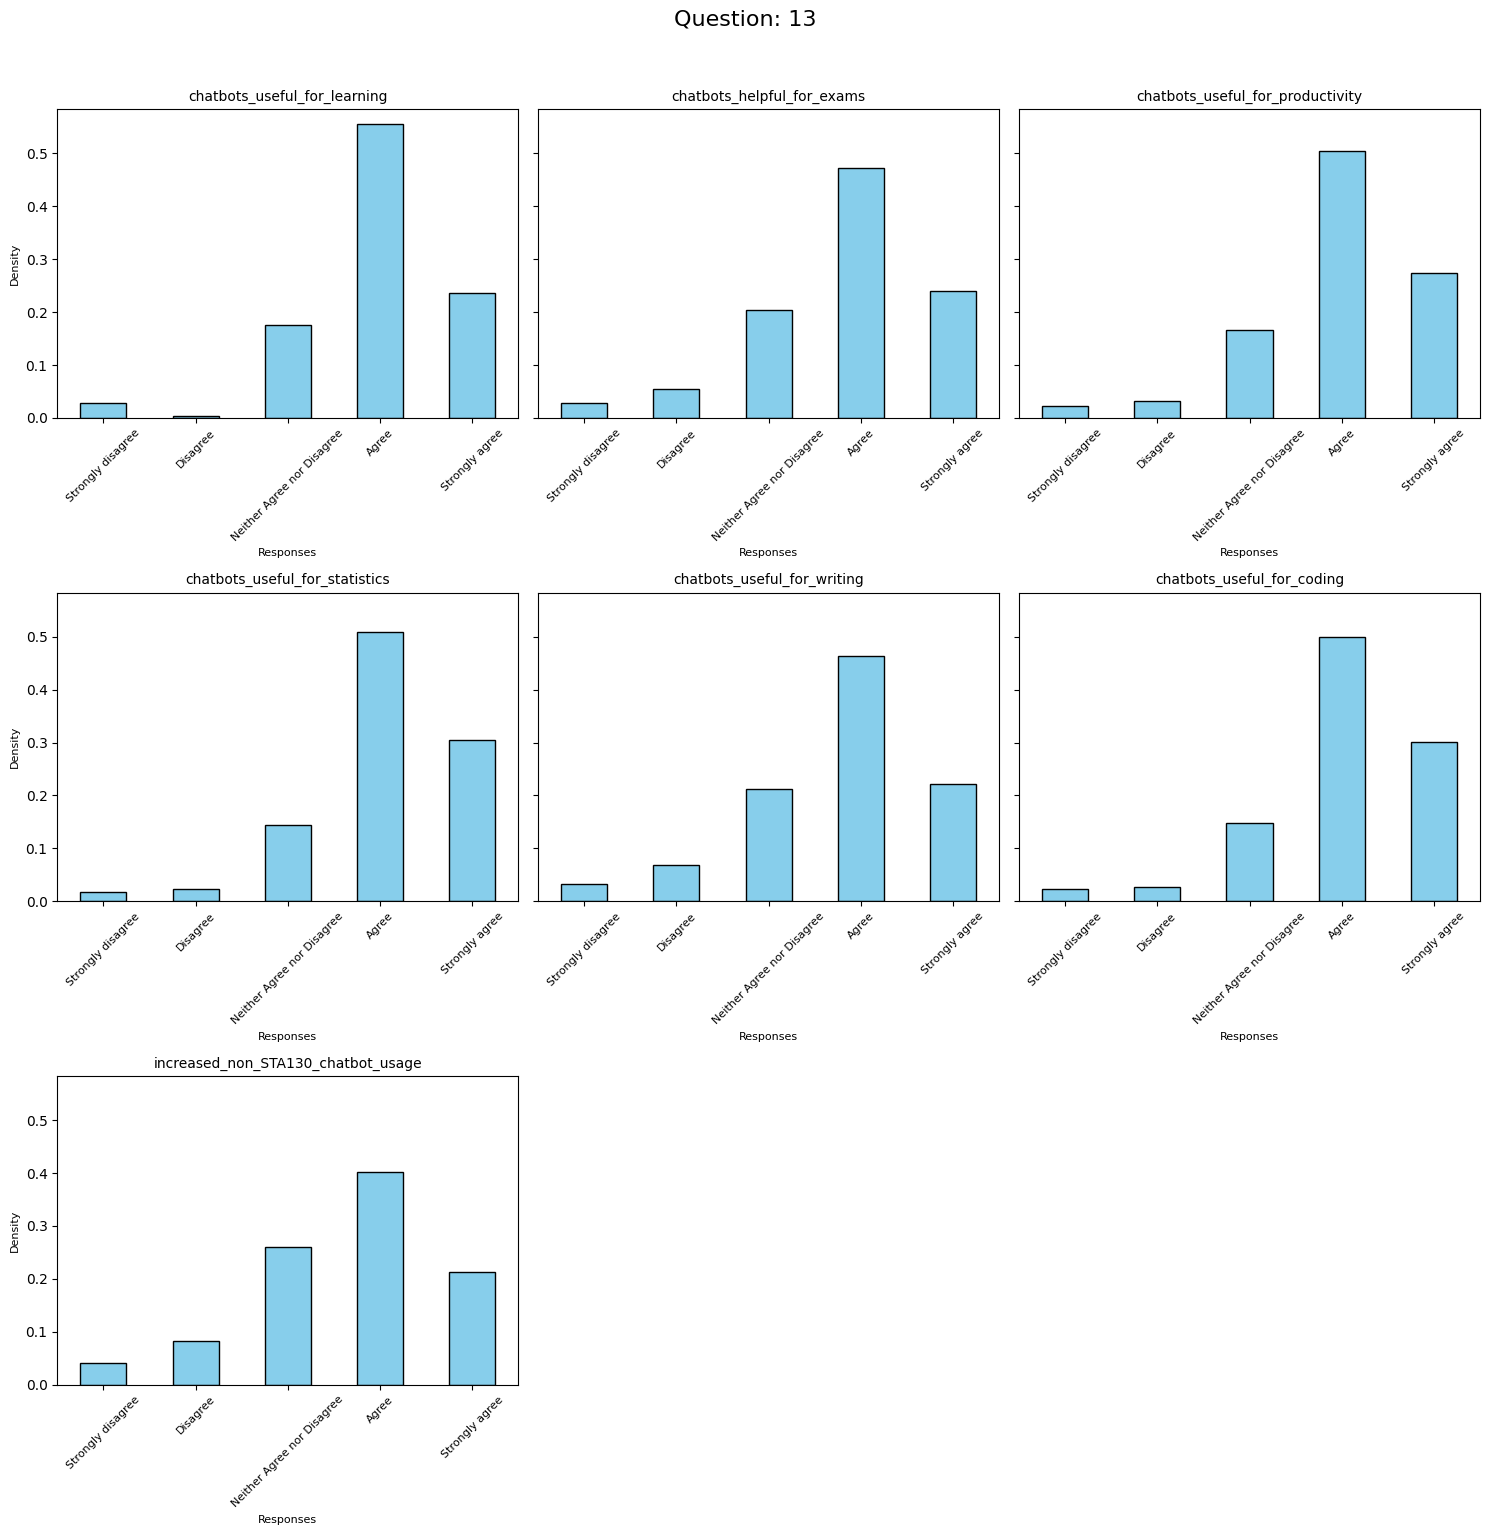

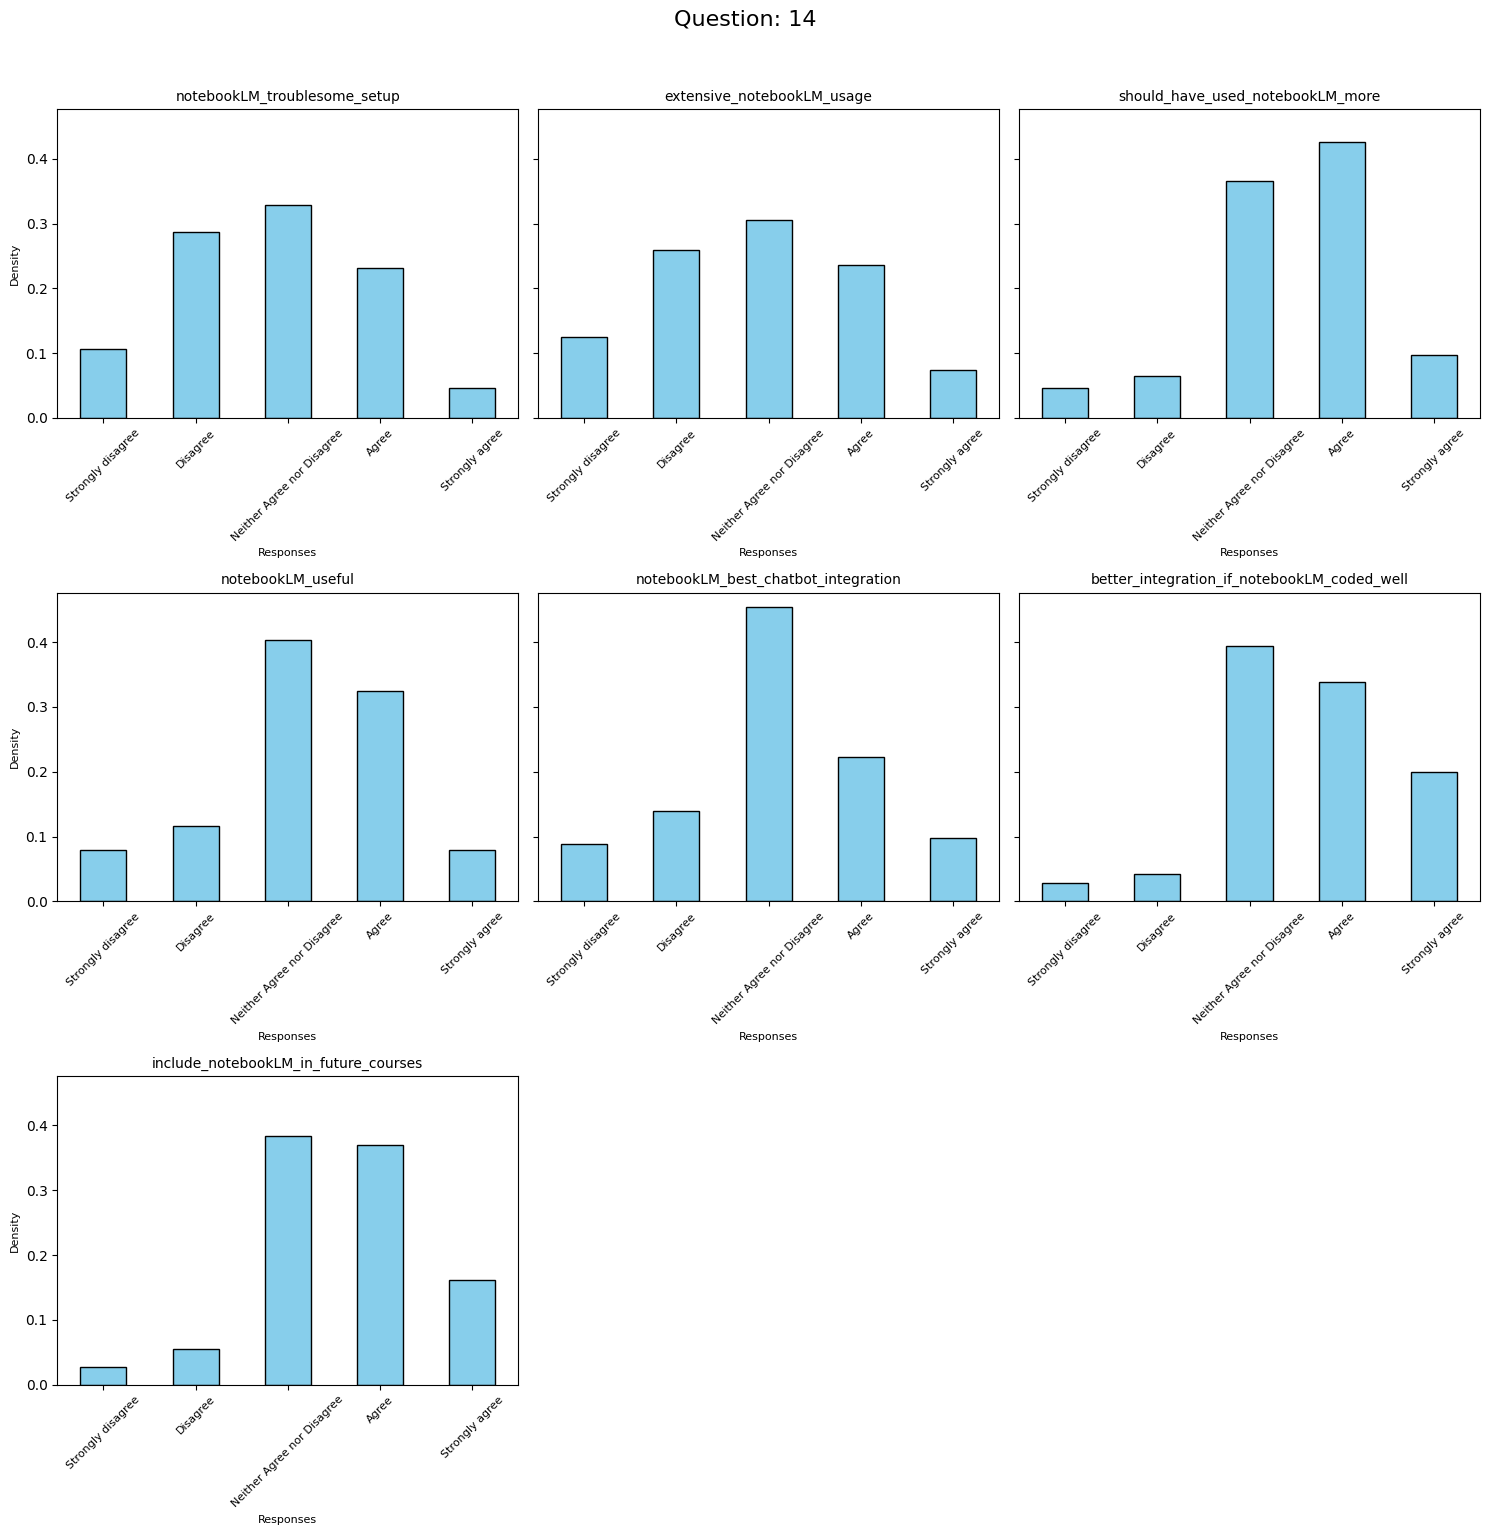

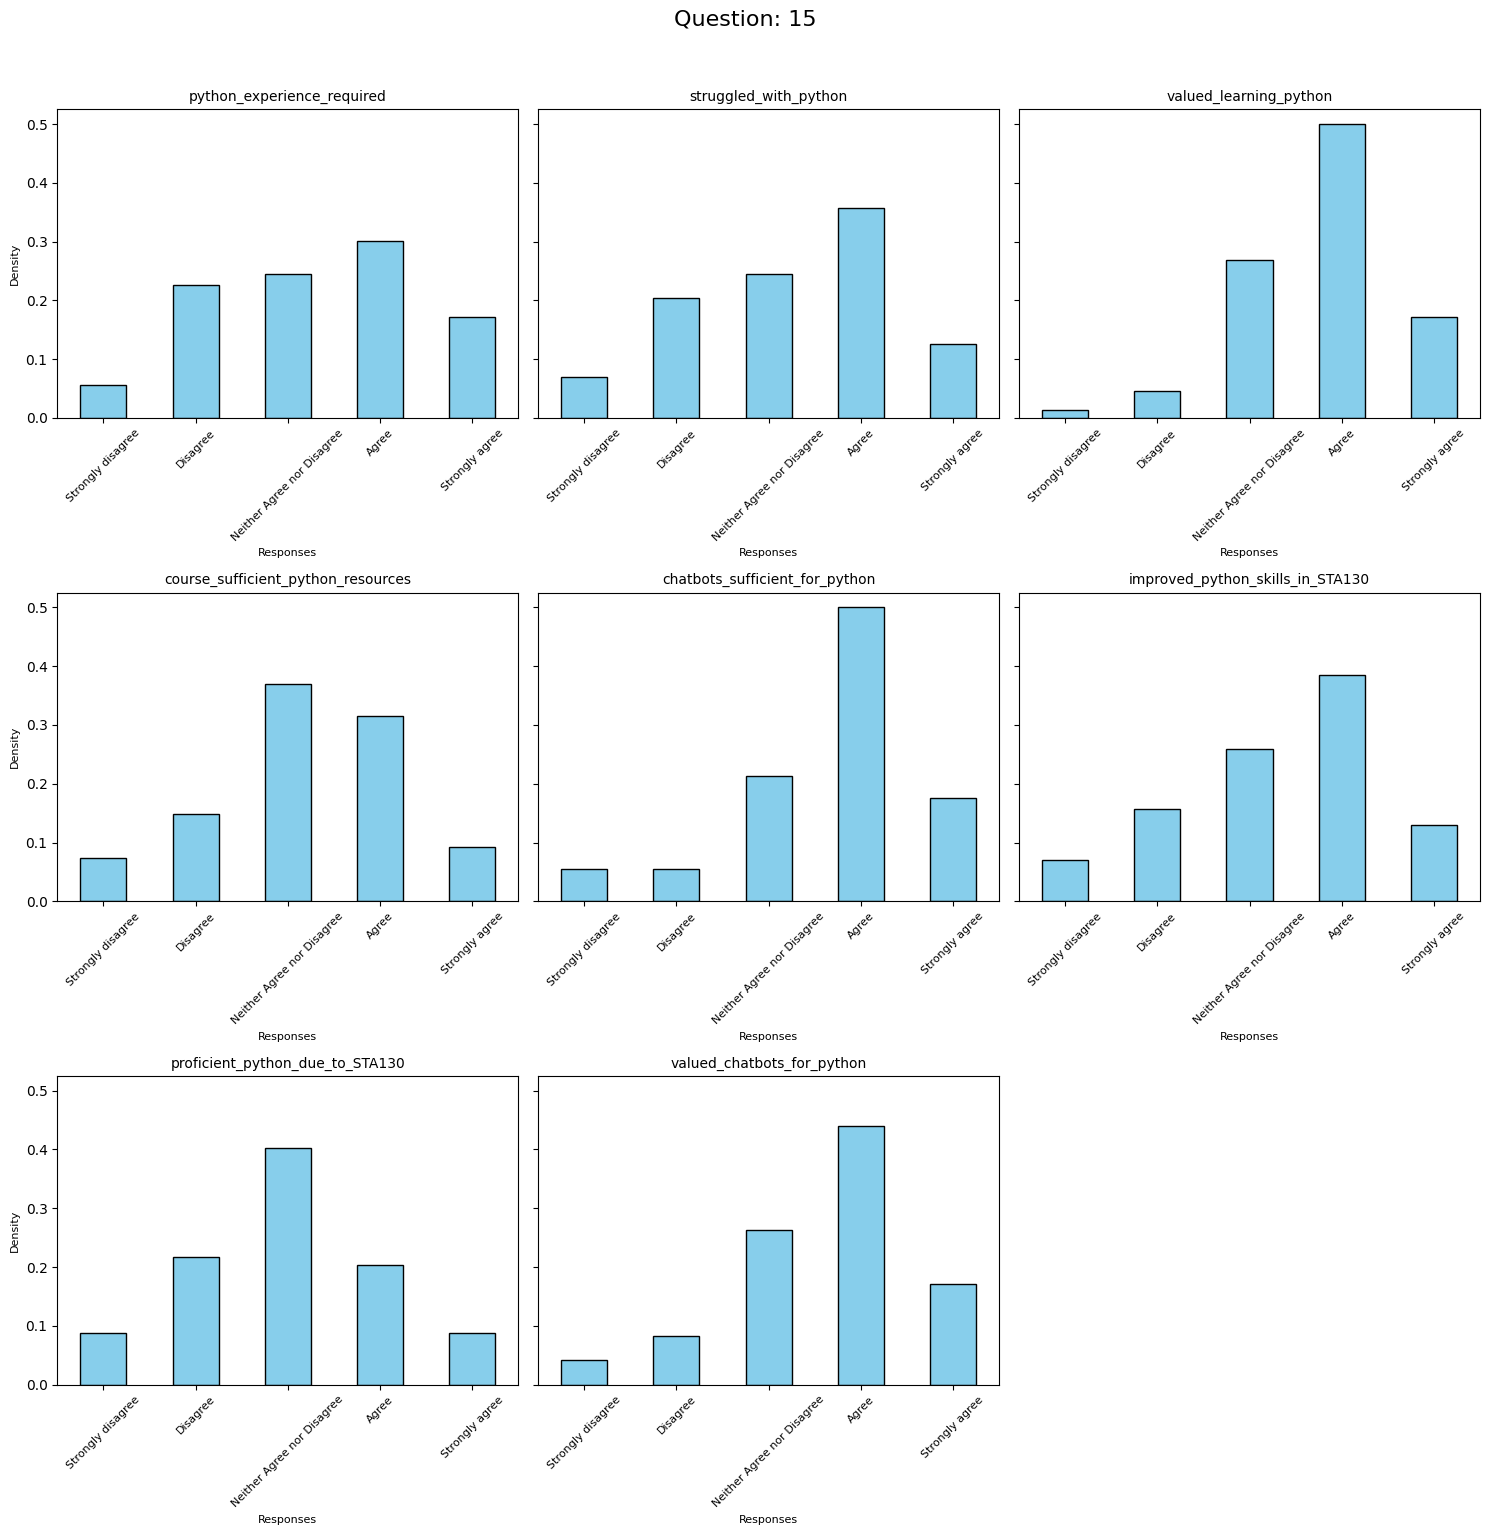

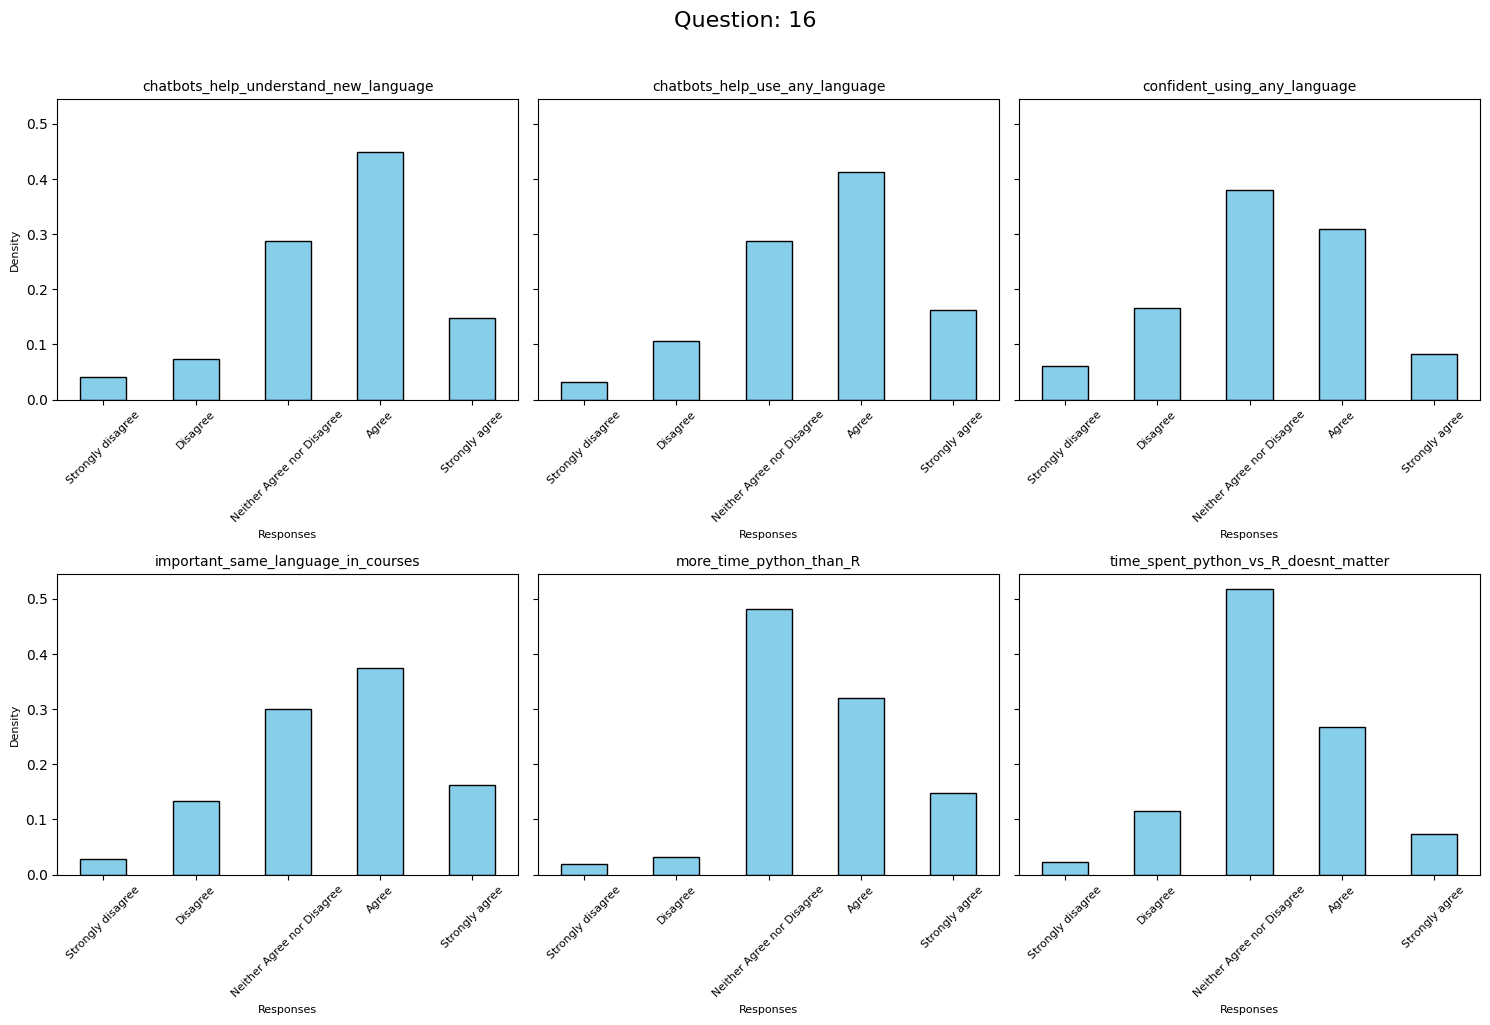

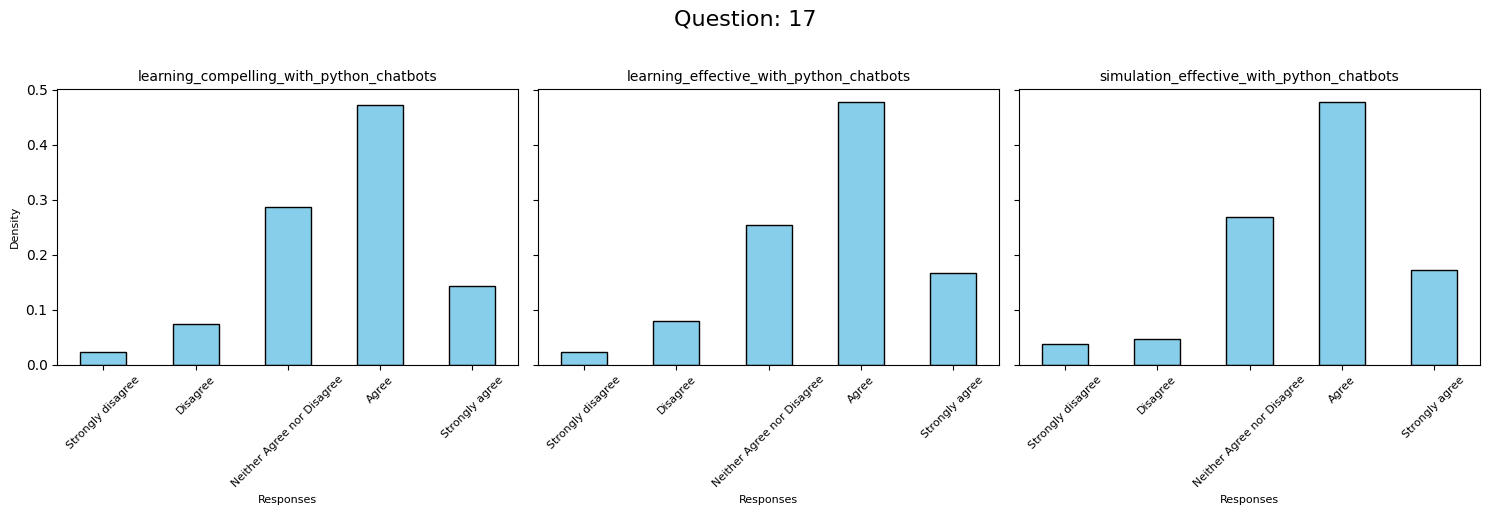

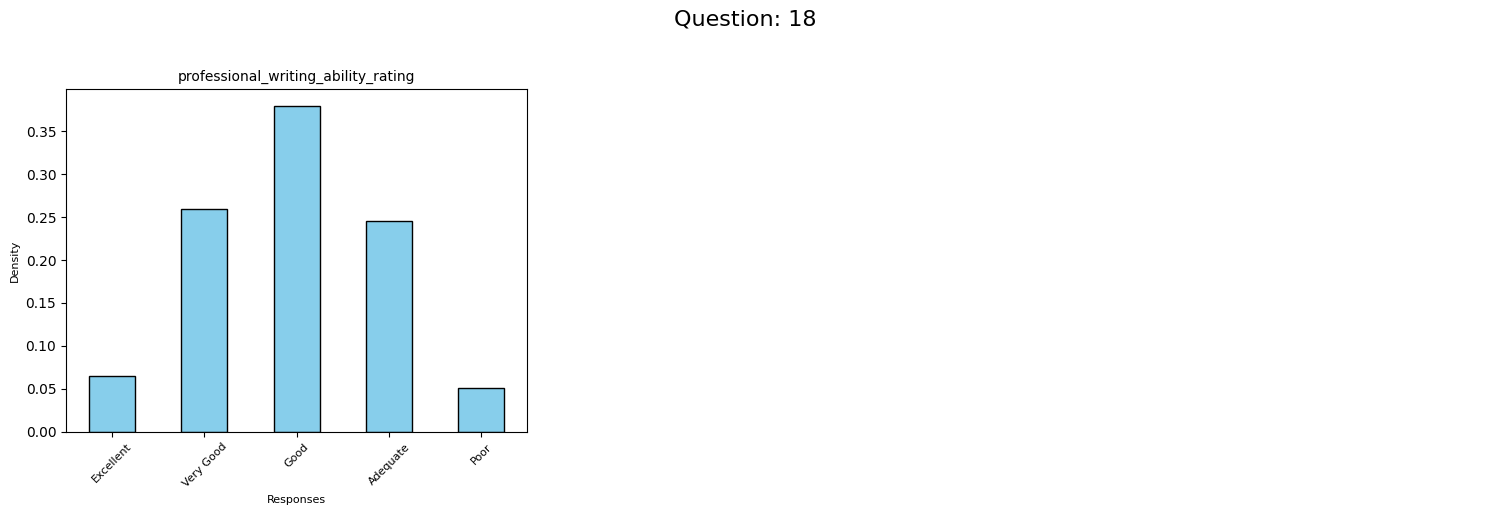

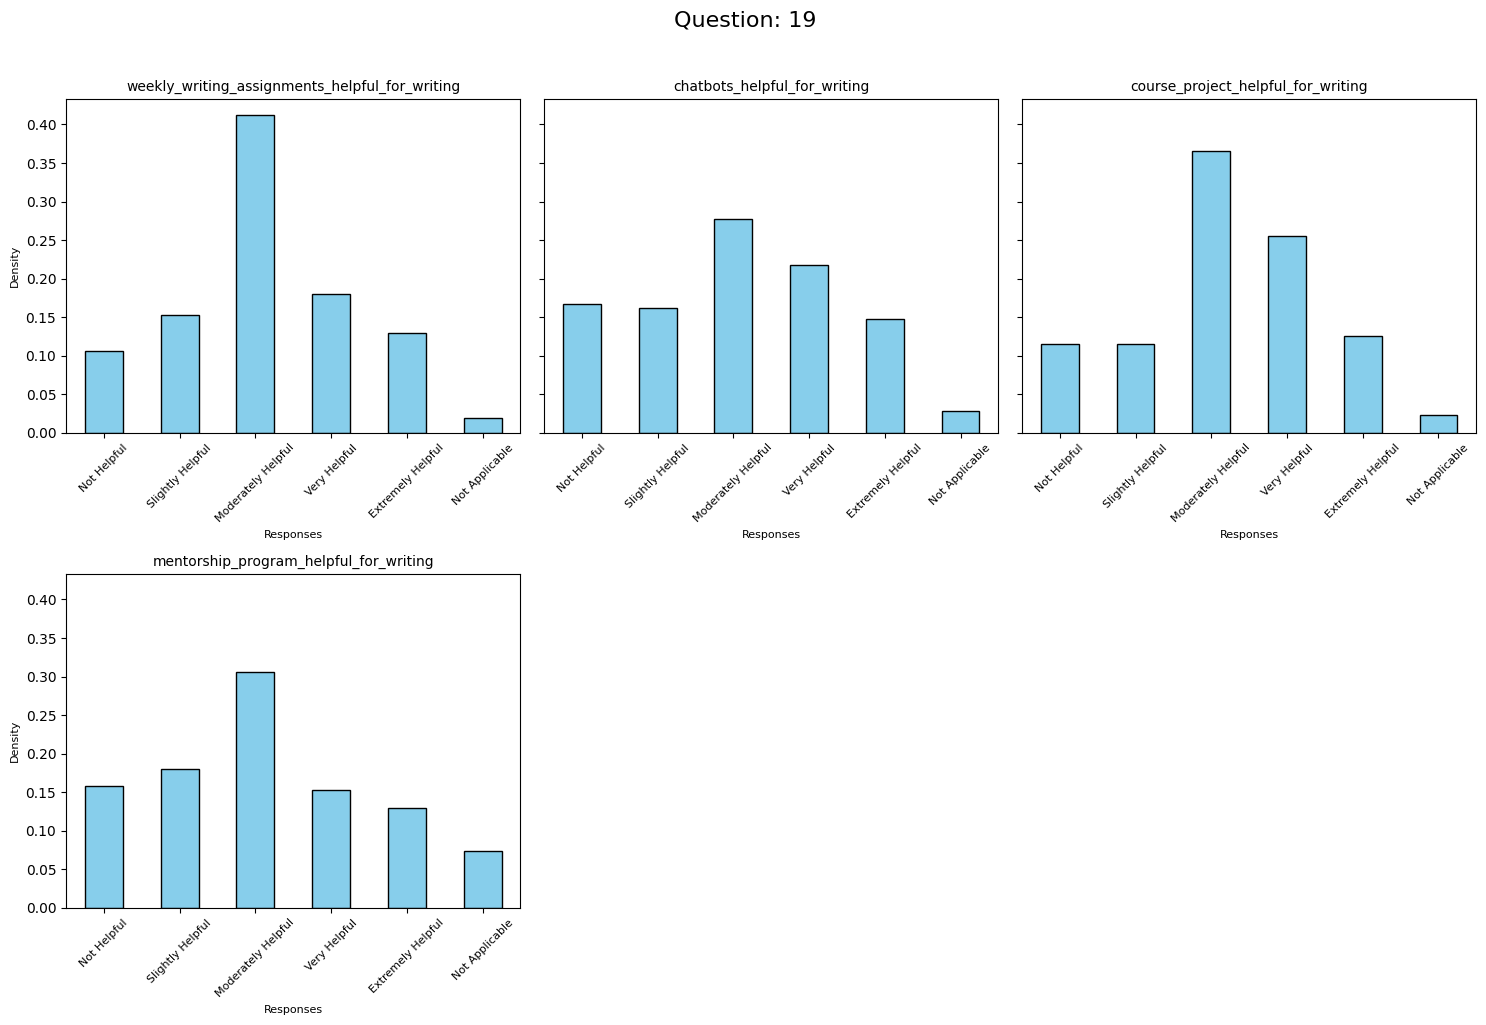

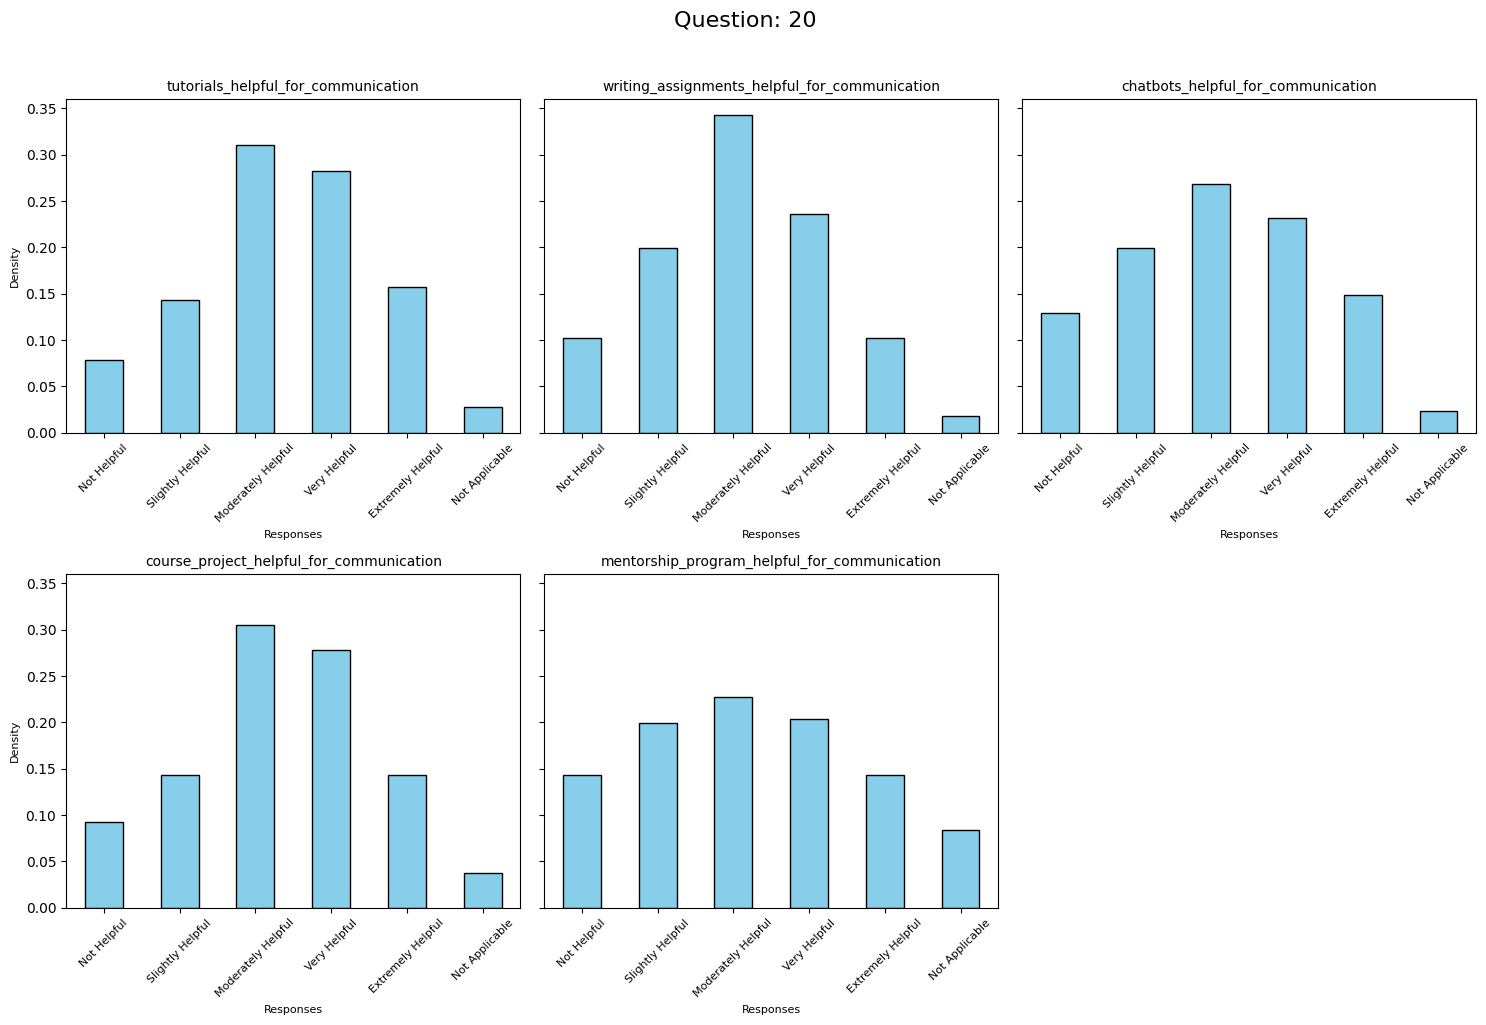

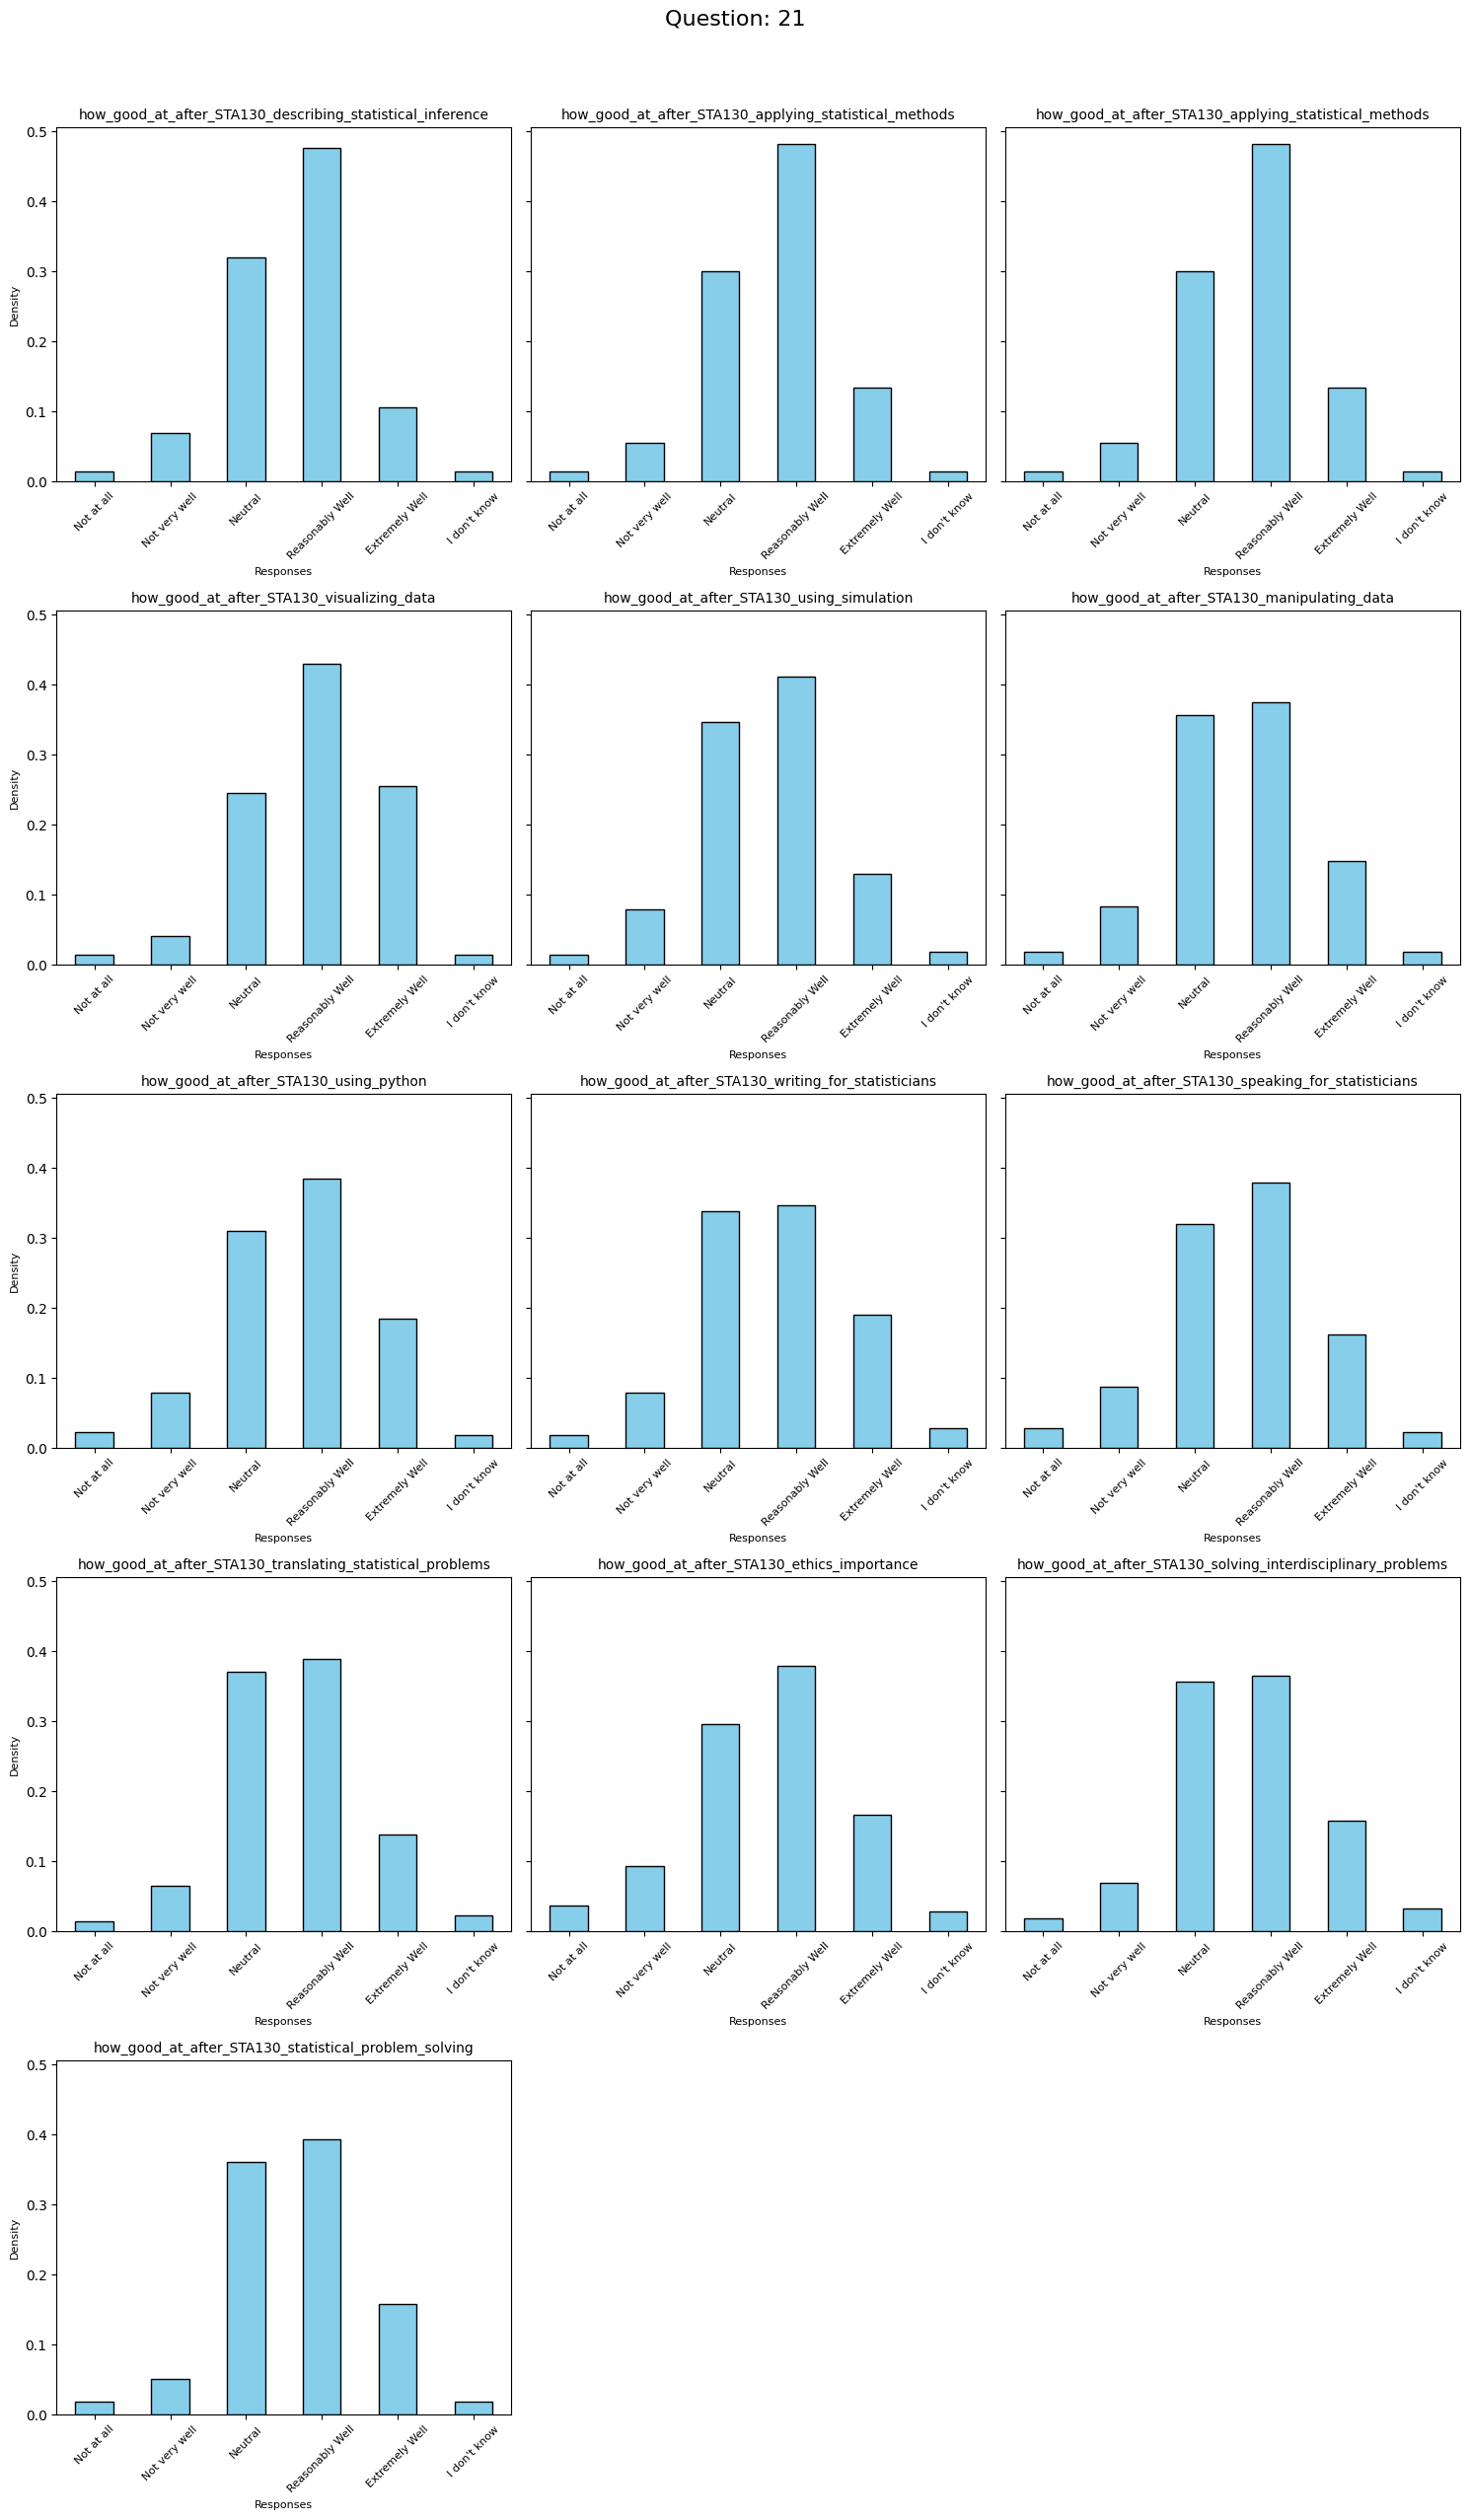

In [26]:
generate_barplots(
    data=F24_post.iloc[:, 6:-3],
    glossary=F24_glossary,
    grouping_column='Question Number',
    variable_column='Variable_Names'
)